In [1]:
import os
import h5py
import numpy as np
from scipy.signal import butter, filtfilt

from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

## Single Subject Analysis

Do analysis on one single subject (`S01`), run on the file `S01_F_CL_Sil_50_100.mat`. 

### 0. Define Initial Parameters

In [3]:
# Specify the folder path relative to the current directory
folder_path = "Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight"
file_path = os.path.join(folder_path, "S01_F_CL_Sil_50_100.mat")

# Parameters
sampling_rate = 256 # Hz

# Define frequency bands
frequency_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 25),
    "Gamma": (25, 100)
}

# Initialize classifiers
classifiers = {
        "LDA": LinearDiscriminantAnalysis(),
        "SVM": SVC(kernel='linear', random_state=42),
        "LogisticRegression": LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
    }

### 1. Extract Trials (Epoching)

Given a raw data file (within-subject data), extract the 12 easy and 12 hard trials for the subject. 

In short, extract the first 30 seconds of the easy trials data, and the last 30 seconds of the hard trials data.

We should obtain two arrays, one for easy trials and one for hard trials, each with shape `(n_trials=12, n_channels=64, n_features=t_seconds * sampling_rate=30*256)`

In [5]:
def extract_trials(filepath, sampling_frequency = 256, sample_duration = 30, downsample_rate = 1):
    with h5py.File(filepath, 'r') as f:
        raw_eeg_data = np.array(f['actualVariable']['EEG_full']['data']).T[:64]
        events = f['actualVariable']['EEG_full']['event']
        event_labels = []
        
        for i in range(len(events['type'])):
            event_type_ref = events['type'][i][0]
            event_latency_ref = events['latency'][i][0]
            
            event_type = ''.join(chr(x) for x in f[event_type_ref][:].flatten())
            event_latency = f[event_latency_ref][()][0]
            event_labels.append((event_type, event_latency))
        
        easy_data_list = []
        hard_data_list = []
        
        trial_starts = []
        trial_ends = []
        
        for event, time in event_labels:
            if event == "START-F_CL_Sil_50_100":
                trial_starts.append(time)
            elif event == "boundary":
                trial_ends.append(time)
        trial_ends.append(event_labels[-1][1])
        
        num_trials = len(trial_starts)
        for trial_idx in range(num_trials):
            start_time = trial_starts[trial_idx]
            end_time = trial_ends[trial_idx]
            start_sample = int(start_time)
            end_sample = int(end_time)
            
            trial_data = raw_eeg_data[:, start_sample:end_sample]
            trial_duration = end_time - start_time
            num_samples_in_trial = trial_data.shape[1]
            
            if trial_idx % 2 == 0:
                data_segment = trial_data[:, :sample_duration*sampling_frequency]
                if np.shape(data_segment)[1] != sample_duration*sampling_frequency:
                    print("skipped trial")
                    continue
                data_segment = data_segment[:, ::downsample_rate]
                easy_data_list.append(data_segment)
            else:
                data_segment = trial_data[:, -sample_duration*sampling_frequency:]
                if np.shape(data_segment)[1] != sample_duration*sampling_frequency:
                    print("skipped trial")
                    continue
                data_segment = data_segment[:, ::downsample_rate]
                hard_data_list.append(data_segment)
        
        easy_data_array = np.array(easy_data_list)  # Shape: (n_trials=12, n_channels=64, n_features=t_seconds * sampling_rate=30*256)
        hard_data_array = np.array(hard_data_list)  # Shape: (n_trials=12, n_channels=64, n_features=t_seconds * sampling_rate=30*256)
    return easy_data_array, hard_data_array

In [6]:
easy_trials, hard_trials = extract_trials(file_path, downsample_rate=5)

/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


In [7]:
easy_trials.shape, hard_trials.shape

((12, 64, 1536), (12, 64, 1536))

### 2. Extract Features Per Electrode/Channel

Extract the **delta (0.5 - 4 Hz), theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 25 Hz), and gamma (25 - 100 Hz)** frequency bands per channel. 

Each frequency band is extracted using a **4th-order Butterworth filter**, bandlimited on the specified frequencies. 

In [25]:
# Define the bandpass filter
def bandpass_filter(data, low_freq, high_freq, sampling_rate):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, Wn=[low, high], btype='band')  # 4th order Butterworth bandpass filter
    filtered_data = filtfilt(b, a, data, axis=1)  # Apply the filter along the time axis
    return filtered_data

# Filter trials for each band
def freq_bands(easy_trials, hard_trials, downsample_rate = 1):
    
    band_data = {}
    for band, (low_freq, high_freq) in frequency_bands.items():
        easy_filtered = bandpass_filter(easy_trials, low_freq, high_freq, sampling_rate*downsample_rate)
        hard_filtered = bandpass_filter(hard_trials, low_freq, high_freq, sampling_rate*downsample_rate)
        band_data[band] = {
            "Easy": easy_filtered,  # Shape: (n_trials, n_channels, n_features)
            "Hard": hard_filtered   # Shape: (n_trials, n_channels, n_features)
        }
    return band_data


In [10]:
# Example: Access Delta band data for Easy trials
delta_easy_trials = band_data["Delta"]["Easy"]
delta_hard_trials = band_data["Delta"]["Hard"]

### 3. Train Classifiers

Prepare data for **all 5 bands together** AND **individually**. Train classifiers on them separately. 

#### 3.1 Prepare Data 

The **labels** correspond to the **difficulty level** of each trial:
- `0` (**Easy Trials**): Tasks with lower difficulty (less challenging flight paths)
- `1` (**Hard Trials**): Tasks with higher difficulty (more challenging flight paths)

EEG data is divided into trials for **Easy** and **Hard** conditions. Each trial contains 64 EEG channels, along with a sequence of sampled EEG data points (7680 samples for a 30-second trial at 256 Hz). 

The data is processed in two ways:
- **All Bands Combined**: Features from all frequency bands are concatenated for each trial to create a comprehensive feature set.
- **Individual Bands**: Features from each frequency band are prepared separately for analysis.

In [13]:
# Prepare data for all bands together
def prepare_all_bands_data(band_data):
    X = []
    y = []
    for label, condition in enumerate(["Easy", "Hard"]):  # 0 for Easy, 1 for Hard
        trials = [band_data[band][condition] for band in frequency_bands.keys()]
        for trial_idx in range(trials[0].shape[0]):  # Iterate over trials
            # Concatenate features from all bands
            feature_vector = []
            for band_trials in trials:
                trial = band_trials[trial_idx]  # Shape: (n_channels, n_features)
                
                # Compute features (mean and std across channels)
                mean_features = np.mean(trial, axis=1)  # Mean across time for each channel
                std_features = np.std(trial, axis=1)    # Std across time for each channel
                band_features = np.concatenate([mean_features, std_features])  # Combine features
                feature_vector.extend(band_features)
            X.append(feature_vector)
            y.append(label)
    return np.array(X), np.array(y)

# Prepare data for all bands combined
X_all_bands, y_all_bands = prepare_all_bands_data(band_data)

In [14]:
# Prepare data for a single band
def prepare_single_band_data(band_data):
    # Prepare data for individual bands
    X_individual_bands = {}
    y_individual_bands = {}    
    for band in frequency_bands.keys():
        X = []
        y = []
        for label, condition in enumerate(["Easy", "Hard"]):  # 0 for Easy, 1 for Hard
            trials = band_data[band][condition]
            for trial in trials:  # Shape: (n_channels, n_features)
                # Compute features (mean and std across channels)
                mean_features = np.mean(trial, axis=1)  # Mean across time for each channel
                std_features = np.std(trial, axis=1)    # Std across time for each channel
                feature_vector = np.concatenate([mean_features, std_features])  # Combine features
                X.append(feature_vector)
                y.append(label)
        X_individual_bands[band] = np.array(X)
        y_individual_bands[band] = np.array(y)
    return X_individual_bands, y_individual_bands

In [15]:
# Print shapes for verification
print(f"All Bands Combined: {X_all_bands.shape}")
X_individual_bands, y_individual_bands = prepare_single_band_data(band_data)
for band, X in X_individual_bands.items():
    print(f"{band} Band: {X.shape}")

All Bands Combined: (24, 640)
Delta Band: (24, 128)
Theta Band: (24, 128)
Alpha Band: (24, 128)
Beta Band: (24, 128)
Gamma Band: (24, 128)


In [16]:
# Concatenate all bands data with individual bands' data for evaluation
X_datasets = {"All Bands": (X_all_bands, y_all_bands)}
for band, X in X_individual_bands.items():
    X_datasets[band] = (X, y_individual_bands[band])

#### 3.2 Train & Evaluate Classifiers

Train and Evaluate the results trained on:
- **Linear Discriminant Analysis (LDA)**
- **Support Vector Machines (SVM)**
- **Logistic Regression**

Use **Leave-One-Out Cross-Validation (LOOCV) accuracy** on the 12 epoched trials for evaluation. 

Plot the results for **all frequency bands** and **each individual frequency band**. 

In [18]:
# Function to train and evaluate a classifier using LOOCV
def train_evaluate_classifier(classifier, X, y):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the classifier
        classifier.fit(X_train, y_train)

        # Predict on the test set
        y_pred.append(classifier.predict(X_test)[0])
        y_true.append(y_test[0])

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [19]:
# Train classifiers for individual bands and all bands
def evaluate_classifiers(X_datasets, classifiers):
    results = {}
    for dataset_name, (X, y) in X_datasets.items():
        results[dataset_name] = {}

        for clf_name, clf in classifiers.items():
            accuracy = train_evaluate_classifier(clf, X, y)
            results[dataset_name][clf_name] = accuracy

    return results

# Evaluate classifiers
X_datasets = {"All Bands": (X_all_bands, y_all_bands)}  # Add all bands combined dataset
for band, X in X_individual_bands.items():
    X_datasets[band] = (X, y_individual_bands[band])  # Add individual bands

In [20]:
# Call the function and evaluate classifiers
results = evaluate_classifiers(X_datasets, classifiers)

In [21]:
# Print results
print("Classifier Performance (LOOCV Accuracy):")
for dataset_name, metrics in results.items():
    print(f"{dataset_name}:")
    for clf_name, accuracy in metrics.items():
        print(f"  {clf_name}: {accuracy:.2f}")

Classifier Performance (LOOCV Accuracy):
All Bands:
  LDA: 0.79
  SVM: 0.92
  LogisticRegression: 0.83
Delta:
  LDA: 0.67
  SVM: 0.67
  LogisticRegression: 0.71
Theta:
  LDA: 0.62
  SVM: 0.75
  LogisticRegression: 0.79
Alpha:
  LDA: 0.75
  SVM: 0.58
  LogisticRegression: 0.58
Beta:
  LDA: 0.50
  SVM: 0.71
  LogisticRegression: 0.79
Gamma:
  LDA: 0.75
  SVM: 0.83
  LogisticRegression: 0.83


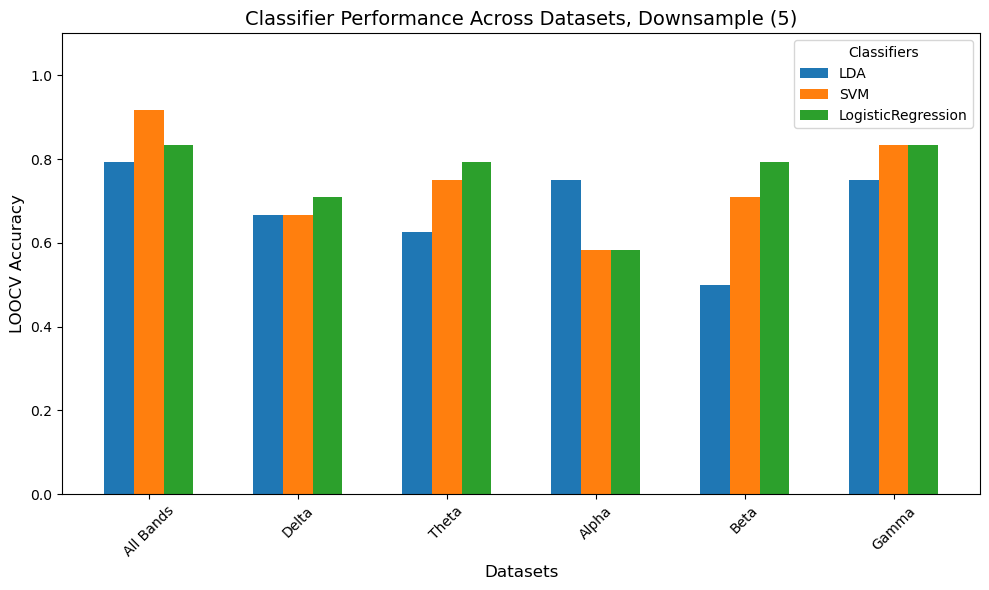

In [27]:
# Plot classifier results

# Function to plot classifier results
def plot_results(results, downsample_rate):
    datasets = list(results.keys())
    classifiers = list(next(iter(results.values())).keys())
    
    # Prepare data for plotting
    accuracies = np.array([[results[dataset][clf] for clf in classifiers] for dataset in datasets])
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(datasets))  # Position of datasets on x-axis

    # Plot bars for each classifier
    plt.figure(figsize=(10, 6))
    for i, clf in enumerate(classifiers):
        plt.bar(x + i * bar_width, accuracies[:, i], width=bar_width, label=clf)

    # Add labels, title, and legend
    plt.xlabel("Datasets", fontsize=12)
    plt.ylabel("LOOCV Accuracy", fontsize=12)
    plt.title(f"Classifier Performance Across Datasets, Downsample ({downsample_rate})", fontsize=14)
    plt.xticks(x + bar_width, datasets, rotation=45, fontsize=10)
    plt.ylim(0, 1.1)  # Accuracy ranges from 0 to 1
    plt.legend(title="Classifiers", fontsize=10)
    plt.tight_layout()
    plt.show()

# Call the function to plot results
plot_results(results, 5)

### 4. Add Additional Preprocessing Techniques

e.g., downsampling, ICA, using different filter types, etc. 

See its effect on the LOOCV accuracies. 

In [ ]:
# TODO: Linear preprocessing: downsampling, different bandpass filtering

In [ ]:
# TODO: Different filter types 

In [ ]:
# TODO: Different feature types

In [ ]:
# TODO: Different feature sets (linear and nonlinear - MFCC features, etc.)

## Multi-Subject Analysis

Do analysis on ALL subjects. Run on the file `S{s}_F_CL_Sil_50_100.mat` for all sujects `s`. 

In [29]:
def processAllSubjs(downsample_rate=1):
    all_results = {}
    sampling_rate = 256
    for s in [f"{i:02}" for i in range(1, 21)]:
        if s in ['04', '07', '13', '14']:
            continue
        file_path = f'Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S{s}_F_CL_Sil_50_100.mat'
        easy_trials, hard_trials = extract_trials(file_path, downsample_rate=downsample_rate)
        print(f'Subject {s} epoched')
    
        band_data = freq_bands(easy_trials, hard_trials, downsample_rate)
        
        X_all_bands, y_all_bands = prepare_all_bands_data(band_data)
        
        X_individual_bands, y_individual_bands = prepare_single_band_data(band_data)
    
        X_datasets = {"All Bands": (X_all_bands, y_all_bands)}
        for band, X in X_individual_bands.items():
            X_datasets[band] = (X, y_individual_bands[band])
        
        results = evaluate_classifiers(X_datasets, classifiers)
        all_results[s] = results
        print(f'Subject {s} all bands LDA - {results['All Bands']['LDA']}')
    return all_results

def getAvgAllSubjs(all_results):
    all_results_array = np.zeros((len(all_results), 18))
    for i, s in enumerate(all_results):
        j = 0
        for b in all_results[s]:
            for c in all_results[s][b]:
                all_results_array[i, j] = all_results[s][b][c]
                j += 1
    
    results_avg = {}
    j = 0
    for d in all_results['01']:
        results_avg[d] = {}
        for c in classifiers:
            results_avg[d][c] = all_results_array.mean(axis=0)[j]
            j += 1
    return results_avg

### Add Downsampling

Experiment with downsampling with rates 1 (keep all original data), 2, 5, and 10. 

/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 01 epoched
Subject 01 all bands LDA - 0.75


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 02 epoched
Subject 02 all bands LDA - 0.8125


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 1.0


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 1.0


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 06 epoched
Subject 06 all bands LDA - 0.7391304347826086


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.6956521739130435


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.6086956521739131


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 10 epoched
Subject 10 all bands LDA - 0.8125


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.6956521739130435


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 12 epoched
Subject 12 all bands LDA - 0.7083333333333334


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 15 epoched
Subject 15 all bands LDA - 1.0


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.42857142857142855


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 17 epoched
Subject 17 all bands LDA - 0.8823529411764706


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 18 epoched
Subject 18 all bands LDA - 0.8947368421052632


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 19 epoched
Subject 19 all bands LDA - 0.5217391304347826


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 20 epoched
Subject 20 all bands LDA - 0.7391304347826086


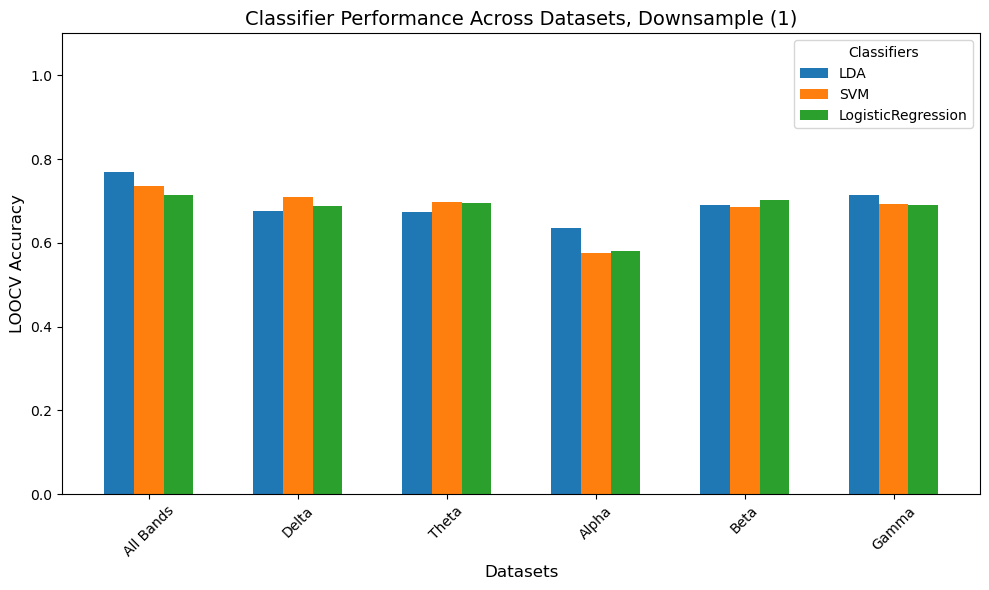

In [35]:
## DOWNSAMPLE 1
all_results = processAllSubjs(downsample_rate=1)
results_avg = getAvgAllSubjs(all_results)
plot_results(results_avg, 1)

/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 01 epoched
Subject 01 all bands LDA - 0.625


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 02 epoched
Subject 02 all bands LDA - 0.75


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 1.0


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 0.8666666666666667


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 06 epoched
Subject 06 all bands LDA - 0.8260869565217391


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.5652173913043478


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.6956521739130435


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 10 epoched
Subject 10 all bands LDA - 0.8125


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.5217391304347826


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 12 epoched
Subject 12 all bands LDA - 0.75


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 15 epoched
Subject 15 all bands LDA - 0.9411764705882353


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.5


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 17 epoched
Subject 17 all bands LDA - 0.8823529411764706


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 18 epoched
Subject 18 all bands LDA - 0.8947368421052632


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 19 epoched
Subject 19 all bands LDA - 0.5652173913043478


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 20 epoched
Subject 20 all bands LDA - 0.9130434782608695


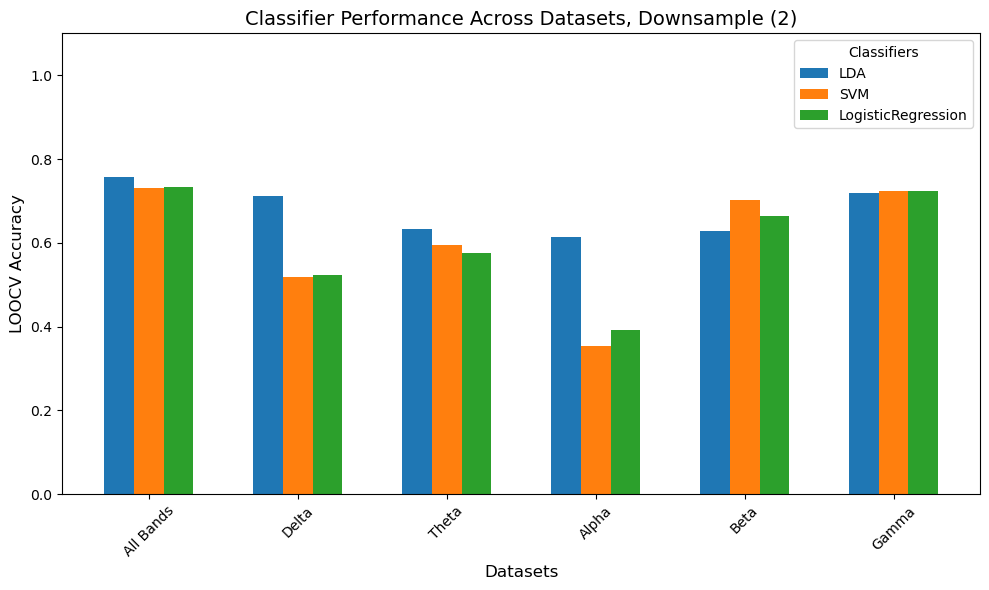

In [36]:
## DOWNSAMPLE 2

all_results = processAllSubjs(downsample_rate=2)
results_avg = getAvgAllSubjs(all_results)
plot_results(results_avg, 2)

/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 01 epoched
Subject 01 all bands LDA - 0.625


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 02 epoched
Subject 02 all bands LDA - 0.4375


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 0.8636363636363636


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 0.8


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 06 epoched
Subject 06 all bands LDA - 0.4782608695652174


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.6956521739130435


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.6956521739130435


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 10 epoched
Subject 10 all bands LDA - 0.5


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.782608695652174


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 12 epoched
Subject 12 all bands LDA - 0.625


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 15 epoched
Subject 15 all bands LDA - 0.8235294117647058


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.5714285714285714


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 17 epoched
Subject 17 all bands LDA - 0.8235294117647058


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 18 epoched
Subject 18 all bands LDA - 0.6842105263157895


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 19 epoched
Subject 19 all bands LDA - 0.7391304347826086


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 20 epoched
Subject 20 all bands LDA - 0.6086956521739131


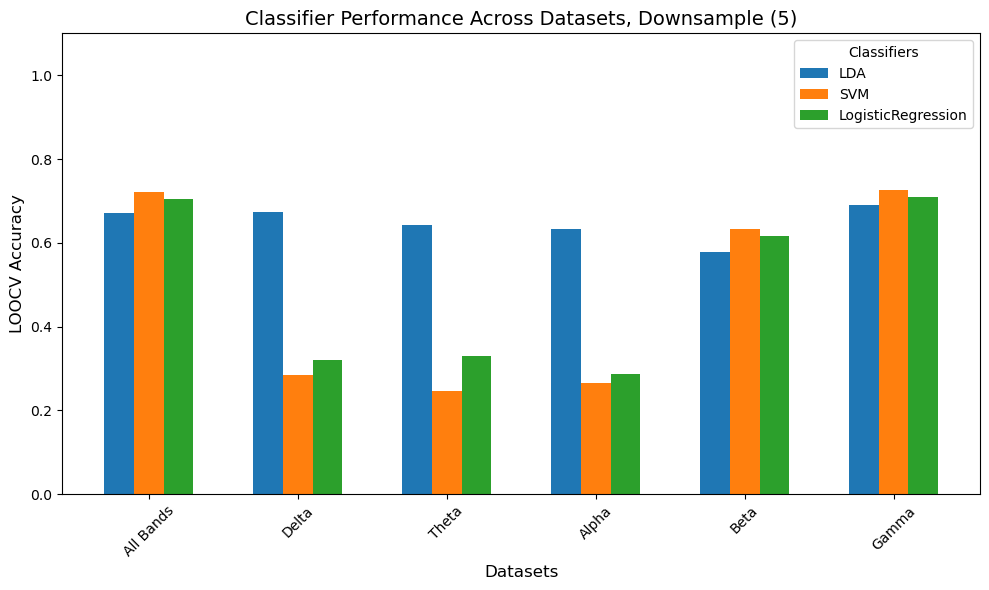

In [37]:
## DOWNSAMPLE 5

all_results = processAllSubjs(downsample_rate=5)
results_avg = getAvgAllSubjs(all_results)
plot_results(results_avg, 5)

/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 01 epoched
Subject 01 all bands LDA - 0.9166666666666666


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 02 epoched
Subject 02 all bands LDA - 0.375


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
Subject 03 epoched
Subject 03 all bands LDA - 0.5454545454545454


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 05 epoched
Subject 05 all bands LDA - 0.8


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 06 epoched
Subject 06 all bands LDA - 0.4782608695652174


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 08 epoched
Subject 08 all bands LDA - 0.6521739130434783


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 09 epoched
Subject 09 all bands LDA - 0.5652173913043478


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 10 epoched
Subject 10 all bands LDA - 0.75


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 11 epoched
Subject 11 all bands LDA - 0.4782608695652174


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 12 epoched
Subject 12 all bands LDA - 0.75


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 15 epoched
Subject 15 all bands LDA - 0.8235294117647058


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
Subject 16 epoched
Subject 16 all bands LDA - 0.7857142857142857


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


Subject 17 epoched
Subject 17 all bands LDA - 0.8235294117647058


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
skipped trial
skipped trial
skipped trial
skipped trial
Subject 18 epoched
Subject 18 all bands LDA - 0.47368421052631576


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 19 epoched
Subject 19 all bands LDA - 0.43478260869565216


/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_sample = int(start_time)
/var/folders/1t/bjxpyljd2576zyjrjv5bnjq40000gn/T/ipykernel_69254/3936134861.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  end_sample = int(end_time)


skipped trial
Subject 20 epoched
Subject 20 all bands LDA - 0.6521739130434783


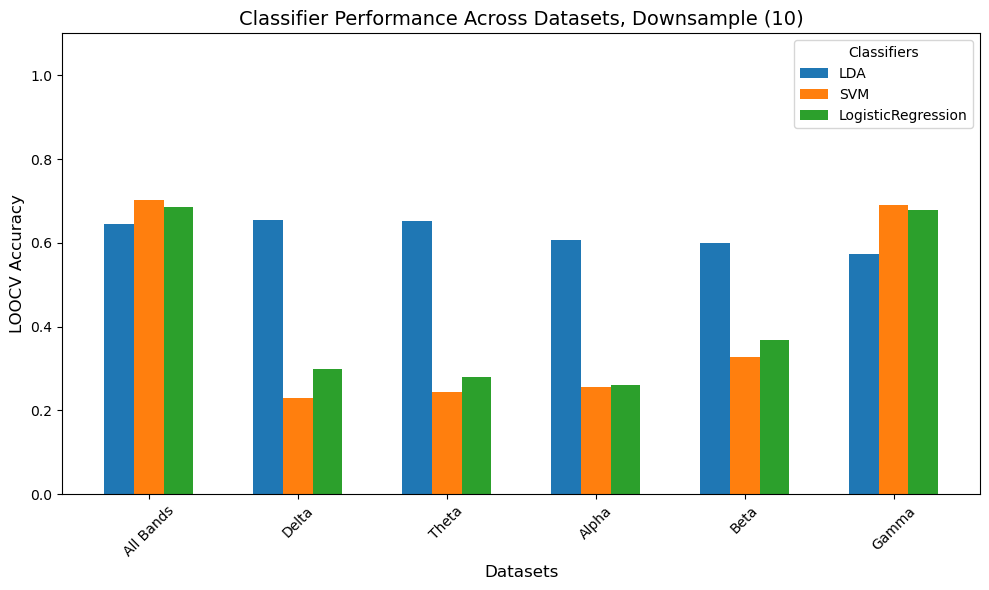

In [38]:
## DOWNSAMPLE 10

all_results = processAllSubjs(downsample_rate=10)
results_avg = getAvgAllSubjs(all_results)
plot_results(results_avg, 10)